In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import skimage.data
from skimage.transform import resize
from skimage.color import rgb2gray

from math import e

In [2]:
inp_image = skimage.data.astronaut()
inp_image = rgb2gray(inp_image)

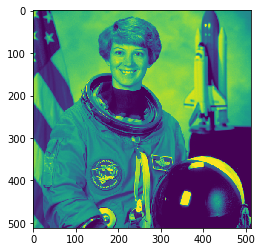

In [3]:
plt.imshow(inp_image)

In [4]:
print(inp_image.shape)

(512, 512)


 #### Function to perform the actual convolution operation along with activation

In [2]:
def conv_operation(test_array, filt, filter_shape, activation=None):
    conv_result = [[] for i in range((test_array.shape[0]-filter_shape)+1)]

    for i in range(test_array.shape[0]):
        for j in range(test_array.shape[1]):
            if (i+filter_shape<=test_array.shape[0]) and (j+filter_shape<=test_array.shape[1]):
                conv_val = np.sum(test_array[i:(i+filter_shape), j:(j+filter_shape)] * filt)
                if activation == 'ReLU':
                    if conv_val > 0:
                        conv_result[i].append(conv_val)
                    else:
                        conv_result[i].append(0)
                elif activation == 'tanh':
                    tanh_val = ((e**conv_val) - (e**(-conv_val)))/((e**conv_val) + (e**(-conv_val)))
                    conv_result[i].append(tanh_val)
                else:
                    conv_result[i].append(conv_val)
                    
    return np.asarray(conv_result)

#### Initialize filters to a random normal distribution

In [3]:
def make_initial_filters(num, size):
    return np.random.randn(num, size, size)

#### Function to create convolution block and generate feature maps using the conv_operation function

In [4]:
def cnn2d_block(inp_array, filter_shape, filters, activation):
    feature_maps = []
    
    for i in range(len(filters)):
        feature_maps.append(conv_operation(inp_array, filters[i], filter_shape, activation))
        
    return np.asarray(feature_maps)

#### Activation Functions

In [5]:
def tanh_actv(feature_maps):
    '''
    hyperbolic tangent (tanh) activation function applied to all the feature maps
    tanh(x) = ((e**x) - (e**(-x))) / ((e**x) + (e**(-x)))
    '''
    
    tanh_f_maps = []
    
    for f_map in feature_maps:
        multiple_rows = []
        for i in f_map:
            row = []
            for j in i:
                row.append(np.tanh(j))
            multiple_rows.append(row)
        tanh_f_maps.append(multiple_rows)
        
    return np.asarray(tanh_f_maps)

In [6]:
def relu_actv(feature_maps):
    '''
    rectified linear units (ReLU) activation function applied to all feature maps
    relu(x) = max(x, 0)
    '''
    
    relu_f_maps = []
    
    for f_map in feature_maps:
        multiple_rows = []
        for i in f_map:
            row = []
            for j in i:
                row.append(np.max([j, 0]))
            multiple_rows.append(row)
        relu_f_maps.append(multiple_rows)
        
    return np.asarray(relu_f_maps)

In [8]:
def derivative_tanh_actv(feature_maps):
    '''
    derivative of the tanh activation function used during backpropagation
    '''
    derv_tanh_f_maps = []
    
    for f_map in feature_maps:
        derv_tanh_f_maps.append(1 - np.tanh(f_map) ** 2)
    
    #print(derv_tanh_f_maps)
    return np.asarray(derv_tanh_f_maps) 

#### Flatten Input Layer

In [27]:
def flatten(feature_maps):
    return np.expand_dims(np.reshape(feature_maps,-1),axis=0)

#### Dense Layer

In [28]:
def dense_layer(inp_arr, weights):
    return inp_arr.dot(weights)

#### Binary Cross  Entropy cost function
−( y * log(p) + (1−y)*log(1−p) )

In [131]:
def binary_cross_entropy_cost(preds_proba, true):
    first_term = true*np.log(preds_proba)
    second_term = (1-true)*np.log(1-preds_proba)
    return -(first_term + second_term)

#### Sigmoid Function
1 / (1+e^(-x))

In [125]:
def sigmoid(dense_layer_output):
    return 1/(1+(np.power(e, np.multiply(-1, dense_layer_output))))

#### Derivative Sigmoid

In [155]:
def derivative_sigmoid(dense_layer_output):
    sig = sigmoid(dense_layer_output)
    return sig*(1-sig)

#### Test Data

In [42]:
x1 = np.array([[0,0,0],[0,0,0],[0,0,0]])
x2 = np.array([[1,1,0],[1,0,0],[0,0,0]])
x3 = np.array([[1,0,0],[0,1,1],[0,1,1]])
x4 = np.array([[1,1,1],[1,1,1],[1,1,1]])
X = np.asarray([x1,x2,x3,x4])

Y = np.array([
    [0],
    [0],
    [1],
    [1]
])

print("X\n", X, end="\n\n")

print("Y\n", Y)

X
 [[[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 0]
  [1 0 0]
  [0 0 0]]

 [[1 0 0]
  [0 1 1]
  [0 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]]]

Y
 [[0]
 [0]
 [1]
 [1]]


#### Forward pass or make predictions

In [169]:
def make_predictions(model, x_data, true_y):
    results = {'preds': [], 'errors':[]}
    for i in range(len(x_data)):
        c1 = cnn2d_block(x_data[i], 2, model['f'][0], None)
        f1 = flatten(c1)
        d1 = dense_layer(f1, model['w'][0])
        preds_sigmoid = sigmoid(d1)
        #cost = binary_cross_entropy_cost(preds_sigmoid, true_y[i])
        results['preds'].append(float(np.squeeze(preds_sigmoid > 0.5)))
        #results['errors'].append(float(np.squeeze(cost)))
    return results

#### Forward Pass, Backward pass and Training

In [157]:
def bp_train(x_data, true_y, model, learning_rate, epochs):
        for epo in range(epochs):
            print('Epoch: ', epo, end="\n")
            for i in range(len(x_data)):
                #print(model, end="\n\n")
                c1 = cnn2d_block(x_data[i], 2, model['f'][0], None)
                c1_tanh = tanh_actv(c1)
                #print(c1, end="\n\n")
                f1 = flatten(c1_tanh)
                #print(f1, end="\n\n")
                #print(model['w'][0], end="\n\n")
                d1 = dense_layer(f1, model['w'][0])
                #print(d1, end="\n\n")
                preds_sigmoid = sigmoid(d1)
                
                cost = binary_cross_entropy_cost(preds_sigmoid, true_y[i])
                #print(cost, end="\n\n")
                #print(np.square(np.squeeze(d1-true_y[i])))
                #break
            
                grad1_1 = preds_sigmoid - true_y[i]
                grad1_2 = derivative_sigmoid(d1)
                grad1 = f1.T.dot(grad1_1*grad1_2)
            
                grad2_1 = (grad1_1).dot(model['w'][0].T)
                grad2_2 = x_data[i]
                grad2_3 = derivative_tanh_actv(c1)
                
                grad2_1_reshape = np.reshape(grad2_1, (2,2))
                grad2_temp = grad2_1_reshape*grad2_3[0]
                grad2 = np.rot90(conv_operation(grad2_2, np.rot90(grad2_temp, 2), grad2_temp.shape[0], None), 2)
            
                print((np.asarray([grad2])), "\n\n")
                #print((grad2_1_reshape), "\n\n")
                print(model['f'][0], "\n\n")
            
                model['f'][0] = model['f'][0] - (grad2*learning_rate)
                model['w'][0] = model['w'][0] - (grad1*learning_rate)
                
                #print(model['f'][0], "\n\n")
                #print("======"*15)
                
                
                #break
            print("Cost: ", cost)
            print("========"*15, end="\n\n\n")

Predictions without training

In [158]:
#dense layer weights and filters initialized
w1 = np.random.randn(4,1) *2
filters = make_initial_filters(1, 2)*2

model = {
    'f' : [filters],
    'w' : [w1]
}

print(filters, end="\n\n")
print(w1, end="\n\n")


make_predictions(model, X, Y)

[[[ 2.03752401  3.07922145]
  [ 1.44250304  1.87011607]]]

[[-2.633286  ]
 [-0.26805924]
 [ 2.74418007]
 [-0.6994963 ]]



{'errors': [0.6931471805599453,
  4.895353455077925e-06,
  3.522323552032658,
  7.221842554486592],
 'preds': [0.0, 0.0, 0.0, 0.0]}

Training the model

In [159]:
bp_train(X, Y, model, 0.2, 20)

Epoch:  0
[[[ 0.  0.]
  [ 0.  0.]]] 


[[[ 2.03752401  3.07922145]
  [ 1.44250304  1.87011607]]] 


[[[ 0.         -0.3079969 ]
  [-0.3079969  -0.23635166]]] 


[[[ 2.03752401  3.07922145]
  [ 1.44250304  1.87011607]]] 


[[[ 0.0033493   0.00246961]
  [ 0.00366378  0.00278422]]] 


[[[ 2.03752401  3.14082083]
  [ 1.50410242  1.9173864 ]]] 


[[[  7.56782080e-08   7.56782080e-08]
  [  7.56782080e-08   7.56782080e-08]]] 


[[[ 2.03685415  3.14032691]
  [ 1.50336967  1.91682956]]] 


Cost:  [[ 1.17373279]]


Epoch:  1
[[[ 0.  0.]
  [ 0.  0.]]] 


[[[ 2.03685413  3.14032689]
  [ 1.50336965  1.91682954]]] 


[[[ 0.         -0.29957457]
  [-0.29957457 -0.22109526]]] 


[[[ 2.03685413  3.14032689]
  [ 1.50336965  1.91682954]]] 


[[[ 0.00274697  0.00215074]
  [ 0.00299357  0.00239742]]] 


[[[ 2.03685413  3.20024181]
  [ 1.56328457  1.96104859]]] 


[[[  4.09708037e-08   4.09708037e-08]
  [  4.09708037e-08   4.09708037e-08]]] 


[[[ 2.03630474  3.19981166]
  [ 1.56268585  1.96056911]]] 


Cos

Predictions after training

In [171]:
make_predictions(model, X, Y)

{'errors': [], 'preds': [0.0, 0.0, 1.0, 1.0]}